# Warning

This notebook requires your copy of the Paradise codebase be at the commit `02f5a24`, which is the commit just before PR [26861](https://github.com/ParadiseSS13/Paradise/pull/26861), which refactored the random spawners used in this notebook.

In [17]:
import datetime
import statistics
from collections import defaultdict
from dataclasses import dataclass
import json
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as pltd
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy.orm import Session, lazyload, joinedload
from sqlalchemy import select, desc, and_, create_engine
import toml
import typed_settings as ts

from paralysis.settings import ParalysisSettings
from paralysis.model import Round, Feedback, LegacyPopulation

from avulto import Path as p, DME, DMM, helpers

In [18]:
import typed_settings as ts
from paralysis.settings import ParalysisSettings
from paralysis.model import Round, Feedback

settings = ts.load(ParalysisSettings, appname="paralysis", config_files=["prod.toml"])

In [424]:
@dataclass(frozen=True)
class SpawnerData:
    feedback_key: str
    feedbacks: list[Feedback]

    def total_spawns(self):
        return sum((spawns for feedback in self.feedbacks for spawns in feedback.values()))

    def spawns_per_round(self):
        return [sum(x.values()) for x in self.feedbacks]

    def counts(self):
        counts = defaultdict(list)
        for feedback in self.feedbacks:
            for name, count in feedback.items():
                counts[name].append(count)
        return counts

    def average(self, path):
        return mean(x for x in self.counts().get(path, [0]))

    def spawn_paths(self):
        return {key for feedback in self.feedbacks for key in feedback.keys() if key}

    def max_round_count(self, path):
        return max(x for x in self.counts().get(path, [0]))

    def mode(self, path):
        return mode(x for x in self.counts().get(path, [0]))

    def means(self):
        means = {name: round(Decimal(sum(count) / len(self.feedbacks)), 2) for name, count in self.counts().items()}
        return sorted(means.items(), key = lambda x: x[1])

    def total_count(self, path):
        return sum(x for x in self.counts().get(path, []))

    def effective_percent(self, path):
        return sum([x / self.total_spawns() for x in self.counts().get(path, [])])

In [14]:
dme = DME.from_file(settings.paradise_root / "paradise.dme")

In [15]:
spawners = dict()
for pth in dme.typesof("/obj/effect/spawner/random_spawners/syndicate/loot"):
    spawners[pth] = dme.types[pth].var_decl("result").const_val

In [16]:
dme.typesof("/obj/effect/spawner/random_spawners/syndicate/loot")

[/obj/effect/spawner/random_spawners/syndicate/loot,
 /obj/effect/spawner/random_spawners/syndicate/loot/level2,
 /obj/effect/spawner/random_spawners/syndicate/loot/level3,
 /obj/effect/spawner/random_spawners/syndicate/loot/level4,
 /obj/effect/spawner/random_spawners/syndicate/loot/stetchkin]

In [19]:
space_base = DMM.from_file(settings.paradise_root / "_maps/map_files/RandomRuins/SpaceRuins/syndiedepot.dmm")

In [20]:
spawner_counts = defaultdict(int)
for coord in space_base.coords():
    tile = space_base.tiledef(*coord)
    for spawner in tile.find("/obj/effect/spawner/random_spawners/syndicate/loot"):
        spawner_counts[tile.prefab_path(spawner)] += 1

In [21]:
spawner_counts

defaultdict(int,
            {/obj/effect/spawner/random_spawners/syndicate/loot: 12,
             /obj/effect/spawner/random_spawners/syndicate/loot/level2: 13,
             /obj/effect/spawner/random_spawners/syndicate/loot/stetchkin: 4,
             /obj/effect/spawner/random_spawners/syndicate/loot/level3: 8,
             /obj/effect/spawner/random_spawners/syndicate/loot/level4: 3})

In [24]:
uplink_item_values = dict()
uplink_item_paths = dme.subtypesof("/datum/uplink_item")
for pth in uplink_item_paths:
    uplink_item = dme.types[pth]
    item = uplink_item.var_decl('item').const_val
    if item is None:
        continue
    cost = uplink_item.var_decl('cost').const_val
    uplink_item_values[item] = cost

In [26]:
helpers.pick_weight_recursive(spawners[p('/obj/effect/spawner/random_spawners/syndicate/loot')])

/obj/item/storage/fancy/cigarettes/cigpack_syndicate

In [28]:
results = list()
for _ in range(10000):
    tc_cost = 0
    for spawner_pth, qty in spawner_counts.items():
        for _ in range(qty):
            result = helpers.pick_weight_recursive(spawners[spawner_pth])
            tc_cost += uplink_item_values.get(result, 0)
    results.append(tc_cost)


In [29]:
df = pd.DataFrame(results)

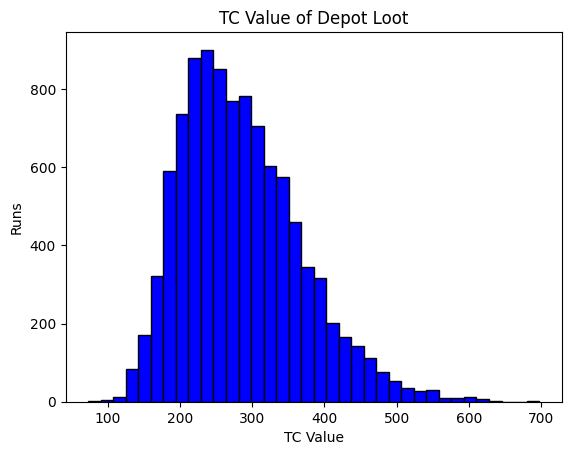

In [30]:
plt.hist(df, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

plt.title('TC Value of Depot Loot')
plt.xlabel('TC Value')
plt.ylabel('Runs')
plt.savefig('depot_loot.png')

In [49]:
quant_5, quant_25, quant_50, quant_75, quant_95

(0    173.0
 Name: 0.05, dtype: float64,
 0    223.0
 Name: 0.25, dtype: float64,
 0    272.0
 Name: 0.5, dtype: float64,
 0    332.0
 Name: 0.75, dtype: float64,
 0    433.0
 Name: 0.95, dtype: float64)

# Warning: None of the code past this point will run as expected.

It expects the existence of a second copy of the Paradise source code which is checked out to the commit before the PR that inflated TC cost. This was used to look at some data about the overall TC expenses that could be found with depot spawners, but I don't have the slightest clue why I needed that data.

In [4]:
tc_inflation_act_ss13 = SS13("D:/ExternalRepos/third_party/ParadiseMaster/paradise.dme")
current_ss13 = SS13("D:/ExternalRepos/third_party/Paradise/paradise.dme")

In [434]:
from avulto import dmlist

In [478]:
UplinkItem = namedtuple('UplinkItem', ['path', 'item', 'name', 'cost', 'item_name'])
def get_uplink_items(ss13):
    uplink_items = dict()
    uplink_item_paths = ss13.dme.paths_prefixed("/datum/uplink_item")
    for pth in uplink_item_paths:
        uplink_item = ss13.dme.typedecl(pth)
        item = uplink_item.value('item')
        if item is None:
            continue
        excludefrom = uplink_item.value('excludefrom')
        if excludefrom is not None:
            if isinstance(excludefrom, dmlist):
                if 'traitor' in excludefrom.keys():
                    print(f"skipping {pth}")
                    continue
            elif 'traitor' in excludefrom:
                print(f"skipping {pth}")
                continue         
        uplinktypes = uplink_item.value('uplinktypes')
        if uplinktypes is not None:
            if isinstance(uplinktypes, dmlist):
                if 'nuclear' in uplinktypes.keys():
                    print(f"skipping {pth}")
                    continue
            elif 'nuclear' in uplinktypes:
                print(f"skipping {pth}")
                continue                         
        cost = uplink_item.value('cost')
        name = uplink_item.value('name')
        uplink_actual_item = ss13.dme.typedecl(item).value('name')
        uplink_items[name] = UplinkItem(pth, item, name, cost, uplink_actual_item)
    return uplink_items

In [479]:
current_items = get_uplink_items(current_ss13)

skipping /datum/uplink_item/ammo/a40mm
skipping /datum/uplink_item/ammo/aps
skipping /datum/uplink_item/ammo/apsap
skipping /datum/uplink_item/ammo/apsfire
skipping /datum/uplink_item/ammo/apshp
skipping /datum/uplink_item/ammo/bioterror
skipping /datum/uplink_item/ammo/bullbuck
skipping /datum/uplink_item/ammo/bulldog_XLmagsbag
skipping /datum/uplink_item/ammo/bulldog_ammobag
skipping /datum/uplink_item/ammo/bulldragon
skipping /datum/uplink_item/ammo/bullmeteor
skipping /datum/uplink_item/ammo/bullslug
skipping /datum/uplink_item/ammo/carbine
skipping /datum/uplink_item/ammo/machinegun
skipping /datum/uplink_item/ammo/rocket
skipping /datum/uplink_item/ammo/smg
skipping /datum/uplink_item/ammo/smg_ammobag
skipping /datum/uplink_item/ammo/sniper/antimatter
skipping /datum/uplink_item/ammo/sniper/basic
skipping /datum/uplink_item/ammo/sniper/haemorrhage
skipping /datum/uplink_item/ammo/sniper/penetrator
skipping /datum/uplink_item/ammo/sniper/soporific
skipping /datum/uplink_item/ammo/

In [12]:
changed_costs = {x for x, y in historical_costs.items() if x in current_costs and y != current_costs[x]}

In [404]:
engine = make_engine("settings.toml")
session = Session(engine)


In [469]:
query = select(Feedback.json, Round.game_mode).filter(and_(
        Feedback.datetime >= datetime(2023, 8, 2),
        Feedback.key_name=='traitor_uplink_items_bought')
    ).join(Round).where(Round.game_mode != "nuclear emergency")

In [465]:
print(query)

SELECT feedback.json, round.game_mode 
FROM feedback JOIN round ON round.id = feedback.round_id 
WHERE feedback.datetime >= :datetime_1 AND feedback.key_name = :key_name_1 AND round.game_mode != :game_mode_1


In [467]:
df = pd.read_sql_query(query, session.connection())

In [470]:
df

,json,game_mode
0,{'data': {'Syndicate Medical Cyborg': {'35': 1...,nuclear emergency
1,"{'data': {'Energy Sword': {'8': 5}, 'X-Ray Vis...",nuclear emergency
2,"{'data': {'Shielded Hardsuit': {'30': 2}, 'Eli...",nuclear emergency
3,"{'data': {'Adrenal Bio-chip': {'4': 1, '8': 2}...",nuclear emergency
4,"{'data': {'Elite Syndicate MODsuit': {'8': 1},...",nuclear emergency
...,...,...
226,"{'data': {'Macrobomb Bio-chip': {'50': 1}, 'Ho...",nuclear emergency
227,"{'data': {'Access Tuner': {'30': 1}, 'Chameleo...",nuclear emergency
228,{'data': {'MODsuit Anti-Slip Module': {'5': 2}...,nuclear emergency
229,"{'data': {'Gygax Exosuit': {'400': 2}, 'Therma...",nuclear emergency


In [407]:
df[df.game_mode == "nuclear emergency"]

,json,game_mode


In [481]:
print(query)
bought_item_counts = defaultdict(int)

for feedback in session.execute(query).scalars():
    for item_name, qty in feedback['data'].items():        
        if item_name in current_items:
            item = current_items[item_name]
            bought_item_counts[str(item.path)] += 1

rows = [(x, y) for x, y in bought_item_counts.items()]

SELECT feedback.json, round.game_mode 
FROM feedback JOIN round ON round.id = feedback.round_id 
WHERE feedback.datetime >= :datetime_1 AND feedback.key_name = :key_name_1 AND round.game_mode != :game_mode_1


In [482]:
bought_item_counts

defaultdict(int,
            {'/datum/uplink_item/jobspecific/ambrosiacruciatus': 29,
             '/datum/uplink_item/stealthy_tools/thermal': 402,
             '/datum/uplink_item/stealthy_weapons/poisonbottle': 173,
             '/datum/uplink_item/stealthy_weapons/sleepy_pen': 580,
             '/datum/uplink_item/bio_chips/storage': 834,
             '/datum/uplink_item/device_tools/emag': 1775,
             '/datum/uplink_item/stealthy_weapons/silencer': 320,
             '/datum/uplink_item/bio_chips/stealthimplant': 581,
             '/datum/uplink_item/device_tools/cipherkey': 1038,
             '/datum/uplink_item/stealthy_tools/agent_card': 816,
             '/datum/uplink_item/explosives/pizza_bomb': 107,
             '/datum/uplink_item/bundles_TC/badass': 796,
             '/datum/uplink_item/suits/modsuit_elite': 331,
             '/datum/uplink_item/jobspecific/pickpocketgloves': 179,
             '/datum/uplink_item/dangerous/guardian': 607,
             '/datum/uplink

In [483]:
df = pd.DataFrame(rows, columns=['path', 'Purchase Count'])

In [395]:
len(df)

0

In [487]:
top_20 = df.sort_values('Purchase Count').tail(int(len(df) * .2))

In [488]:
top_20

,path,Purchase Count
6,/datum/uplink_item/stealthy_weapons/silencer,320
95,/datum/uplink_item/device_tools/hacked_module,321
12,/datum/uplink_item/suits/modsuit_elite,331
60,/datum/uplink_item/explosives/emp,332
44,/datum/uplink_item/device_tools/toolbox,369
27,/datum/uplink_item/stealthy_weapons/garrote,373
18,/datum/uplink_item/stealthy_tools/chameleon,378
22,/datum/uplink_item/explosives/plastic_explosives,385
67,/datum/uplink_item/ammo/pistol,387
1,/datum/uplink_item/stealthy_tools/thermal,402


In [199]:
rounds_rolled = defaultdict(int)

for _ in range(100):
    seen = set()
    for spawner_pth, qty in spawner_counts.items():
        for _ in range(qty):
            if spawner_pth == '/obj/effect/spawner/random_spawners/syndicate/loot/level4' and prob(50):
                continue
            result = pick_weight_recursive(spawners[spawner_pth])
            if result not in seen:
                seen.add(result)
                rounds_rolled[str(result)] += 1

In [486]:
datums_to_items = {x.path: x.item for x in current_items.values()}

In [ ]:
'/obj/item/clothing/suit/jacket/bomber/syndicate'

In [208]:
datums_to_items[p('/datum/uplink_item/badass/bomber')]

/obj/item/clothing/suit/jacket/bomber/syndicate

In [212]:
rounds_rolled[str(datums_to_items[p('/datum/uplink_item/badass/bomber')])]

24

In [275]:
top_20["Loot Odds / 100 rounds"]  = top_20["path"].apply(lambda x: rounds_rolled[str(datums_to_items[p(x)])] / 100.0)

In [252]:
def get_uplink_item_name(datum_pth):
    for uplink_item in current_items.values():
        if uplink_item.path == datum_pth:
            return uplink_item.item_name.replace('\\improper ', '')

def get_uplink_item_tc_count(datum_pth):
    for uplink_item in current_items.values():
        if uplink_item.path == datum_pth:
            return uplink_item.cost
    

In [240]:
get_uplink_item_name("/datum/uplink_item/dangerous/pistol")

'stechkin pistol'

In [489]:
top_20["TC Cost"] = top_20["path"].apply(lambda x: get_uplink_item_tc_count(x))
top_20["Item Name"] = top_20["path"].apply(lambda x: get_uplink_item_name(x))
top_20["Loot Odds / 100 rounds"]  = top_20["path"].apply(lambda x: rounds_rolled[str(datums_to_items[p(x)])] / 100.0)

In [193]:
datums_to_items[p('/datum/uplink_item/stealthy_tools/camera_bug')]

/obj/item/storage/box/syndie_kit/camera_bug

In [490]:
top_20

,path,Purchase Count,TC Cost,Item Name,Loot Odds / 100 rounds
6,/datum/uplink_item/stealthy_weapons/silencer,320,5,suppressor,0.43
95,/datum/uplink_item/device_tools/hacked_module,321,15,hacked AI module,0.00
12,/datum/uplink_item/suits/modsuit_elite,331,45,MOD control unit,0.00
60,/datum/uplink_item/explosives/emp,332,10,boxed EMP kit,0.00
44,/datum/uplink_item/device_tools/toolbox,369,5,suspicious looking toolbox,0.39
27,/datum/uplink_item/stealthy_weapons/garrote,373,30,fiber wire,0.00
18,/datum/uplink_item/stealthy_tools/chameleon,378,10,chameleon kit,0.00
22,/datum/uplink_item/explosives/plastic_explosives,385,5,C4,0.00
67,/datum/uplink_item/ammo/pistol,387,3,pistol magazine (10mm),0.24
1,/datum/uplink_item/stealthy_tools/thermal,402,15,Optical Meson Scanner,0.00


In [491]:
gc = gspread.service_account()
sh = gc.open("Syndie Depot Items")

In [492]:
worksheet = sh.get_worksheet(0)

In [493]:
set_with_dataframe(worksheet, top_20)